# Data Scientist Case Study: Direct Marketing Optimization
## Objective
Maximize revenue from direct marketing campaigns using the provided dummy data.
Business Context: This case study simulates a real-world marketing scenario aimed at optimizing
resource allocation to maximize revenue.

### Data description
- Social-Demographic Information: Age, gender, and bank tenure.
- Product Holdings and Volumes: Details on current accounts, savings accounts, mutual
funds, overdrafts, credit cards, and consumer loans.
- Financial Transactions: Aggregated inflow/outflow on current accounts and average
monthly card turnover over the past three months.
- Sales and Revenue Data: Available for 60% of clients, serving as a training set.

### Approach
I will be building 3 propensity models to score how likely a client is to purchase the product and with the probability, I will calculate the expected revenue by multiplying the predicted revenue/spent for respective product (as this is not part of the tasks, I will use the simple mean for the revenue. Otherwise, I will build a model to predict revenue/spent. I will not go into comparing other models since performance will not be graded.

### Import data

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [377]:
# Reading in input data file (Total 1 description tab and 4 data tab)
pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx',sheet_name=0)

,Sheet,Variable,Description
0,Soc_Dem,Client,client ID
1,NaN,Sex,gender
2,NaN,Age,age [years]
3,NaN,Tenure,tenure with the bank [months]
4,Products_ActBalance,Client,client ID
5,NaN,Count_CA,number of live current accounts
6,NaN,Count_SA,number of live saving accounts
7,NaN,Count_MF,number of live mutual funds
8,NaN,Count_OVD,number of live overdrafts
9,NaN,Count_CC,number of live credit cards


#### Social-Demographic

In [378]:
# import data
Soc_Dem_df = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx',sheet_name=1)
print(Soc_Dem_df.shape)
print(f'unique client id: {Soc_Dem_df.Client.nunique()}')
Soc_Dem_df.head()

(1615, 4)
unique client id: 1615


,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106


In [379]:
Soc_Dem_df.describe(include='all')

,Client,Sex,Age,Tenure
count,1615.000000,1612,1615.000000,1615.000000
unique,NaN,2,NaN,NaN
top,NaN,M,NaN,NaN
freq,NaN,856,NaN,NaN
mean,808.000000,NaN,42.848916,101.339938
std,466.354658,NaN,18.550529,64.917297
min,1.000000,NaN,0.000000,0.000000
25%,404.500000,NaN,29.000000,44.000000
50%,808.000000,NaN,41.000000,97.000000
75%,1211.500000,NaN,57.000000,151.000000


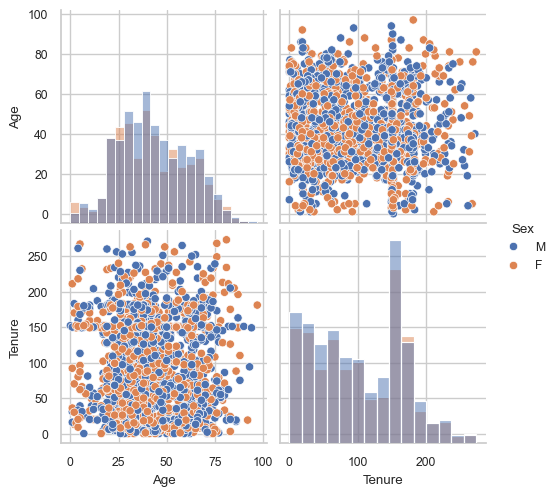

In [380]:
# pairplot to visualize relationship
sns.pairplot(Soc_Dem_df.iloc[:,1:], hue='Sex', diag_kind='hist')

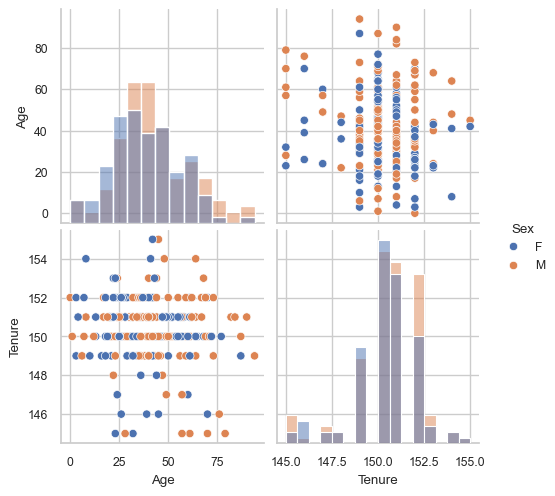

In [381]:
# zooming in to look at Tenure around 150
sns.pairplot(Soc_Dem_df[(Soc_Dem_df['Tenure']>=145) & (Soc_Dem_df['Tenure']<=155)].iloc[:,1:], hue='Sex', diag_kind='hist')

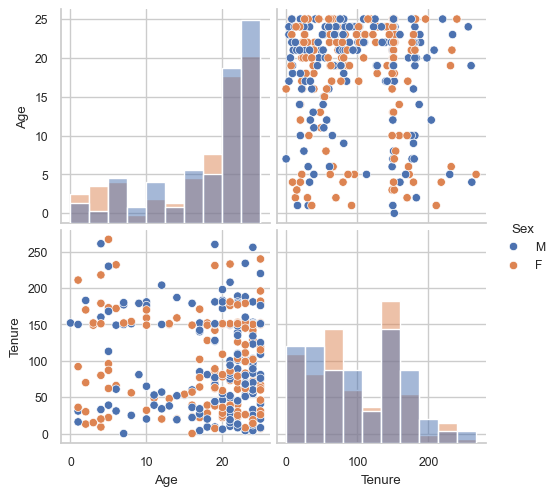

In [382]:
# zooming in to look at Age < 25
sns.pairplot(Soc_Dem_df[(Soc_Dem_df['Age']<=25)].iloc[:,1:], hue='Sex', diag_kind='hist')

In [383]:
# Apply filter to remove records with Tenure around 150 and below 21 years old
Soc_Dem_df_final = Soc_Dem_df[((Soc_Dem_df['Tenure']<149) | (Soc_Dem_df['Tenure']>152)) & (Soc_Dem_df['Age']>=21)]

In [384]:
# create one hot variables for Sex
Soc_Dem_df_final = pd.get_dummies(Soc_Dem_df_final,columns=['Sex'], dtype='int')

In [385]:
# create an Eligible flag for filtering later
Soc_Dem_df_final['Eligible_Flag'] = 1

In [386]:
Soc_Dem_df_final.shape

(1278, 6)

#### Findings on Client data
- Tenure: There are anormalies in Tenure where Tenure is around 150 months. Further zooming in shows that it could be a data error or data migration of legacy systems or during merger because there are case where Tenure > Age. We need to check with Business or IT Software engineer maintaining the source to investigate the reason. Depending on the investigating, we could omit them altogether, impute with mean of the other records or correct the value at source. For now, we will assume they are data errors and omit them.

- Age: There are Client with Age = 0 in the data. Although Age=0 could be insured person new born. But here, I will make the assumption that this Client column contains Account Holder who should be of legal age and also typically marketing will have a set of product requirements who can the product be sold to. I will assume the 3 products can only be sold to above 21 years old and only look at these records. This is only an assumption for this assignment and acknowledging that there are business requirements in real life which I need to pay attention to to avoid regulatory risks.

#### Product

In [387]:
# import product data
Products_ActBalance_df = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx',sheet_name=2)
print(Products_ActBalance_df.shape)
print(f'unique client id: {Products_ActBalance_df.Client.nunique()}')
Products_ActBalance_df.head()

(1615, 13)
unique client id: 1615


,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [388]:
# Fill na for the Count columns
Products_ActBalance_df_final = Products_ActBalance_df.fillna(0)
#Products_ActBalance_df.head()

In [389]:
# create new feature as part of feature engineering
Products_ActBalance_df_final['Total_Asset_Balance'] = Products_ActBalance_df_final[['ActBal_CA','ActBal_SA','ActBal_MF']].sum(axis=1)

In [390]:
Products_ActBalance_df_final['Total_Liability_Balance'] = Products_ActBalance_df_final[['ActBal_OVD','ActBal_CC','ActBal_CL']].sum(axis=1)

In [391]:
Products_ActBalance_df_final['Net_Asset_Balance'] = Products_ActBalance_df_final['Total_Asset_Balance']-Products_ActBalance_df_final['Total_Liability_Balance']

In [392]:
# create function to calculate ratio
def CalcRatio(a, b):
    ratio = a / b
    if (np.isinf(ratio) or np.isnan(ratio)):
        ratio = (1 + a) / (1 + b)
    return ratio

In [393]:
Products_ActBalance_df_final['Gearing_Ratio'] = Products_ActBalance_df_final.apply(lambda x: CalcRatio(x['Total_Liability_Balance'],x['Total_Asset_Balance']), axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5520\1230182725.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = a / b
C:\Users\Admin\AppData\Local\Temp\ipykernel_5520\1230182725.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ratio = a / b


In [394]:
Products_ActBalance_df_final.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Total_Asset_Balance,Total_Liability_Balance,Net_Asset_Balance,Gearing_Ratio
0,1,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.000000,0.0,0.000000,0.0,1333.802857,0.000000,1333.802857,0.000000
1,2,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.000000,0.0,0.000000,0.0,13436.958929,0.000000,13436.958929,0.000000
2,3,1,0.0,1.0,0.0,0.0,0.0,482.654643,0.000000,107.251786,0.0,0.000000,0.0,589.906429,0.000000,589.906429,0.000000
3,4,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.000000,0.0,1110.381786,0.0,1676.277857,1110.381786,565.896071,0.662409
4,5,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.000000,0.0,0.000000,0.0,13433.199643,0.000000,13433.199643,0.000000


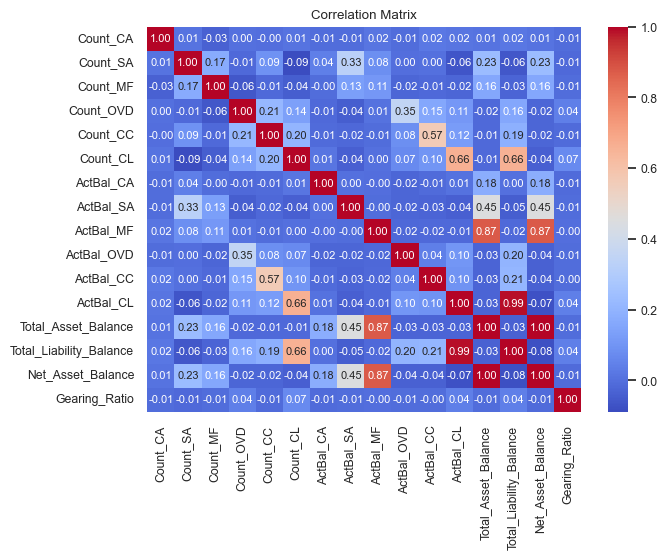

In [395]:
# understanding correlation between variables
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 5))
plt.title('Correlation Matrix')
corr_matrix = Products_ActBalance_df_final.iloc[:,1:].corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 8},cmap='coolwarm',fmt='.2f')
plt.show()

#### Findings on Product
- CA, SA and MF are assets/investments while OVD, CC and CL are more like loans/money owed. From the correlation matrix we can that Client with CA, SA and MF tend to have lesser OVD, CC and CL and those with CL are also more likely to have CC and OVD.
- Most of customers liability is driven by CL while assets are driven by MF. 

#### Financial Transactions

In [396]:
# import financial transactions data
Inflow_Outflow_df = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx',sheet_name=3)
print(Inflow_Outflow_df.shape)
print(f'unique client id: {Inflow_Outflow_df.Client.nunique()}')
Inflow_Outflow_df.head()

(1587, 15)
unique client id: 1587


,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0


In [397]:
# create new features
Inflow_Outflow_df['Net_Volume'] = Inflow_Outflow_df['VolumeDeb'] - Inflow_Outflow_df['VolumeCred']

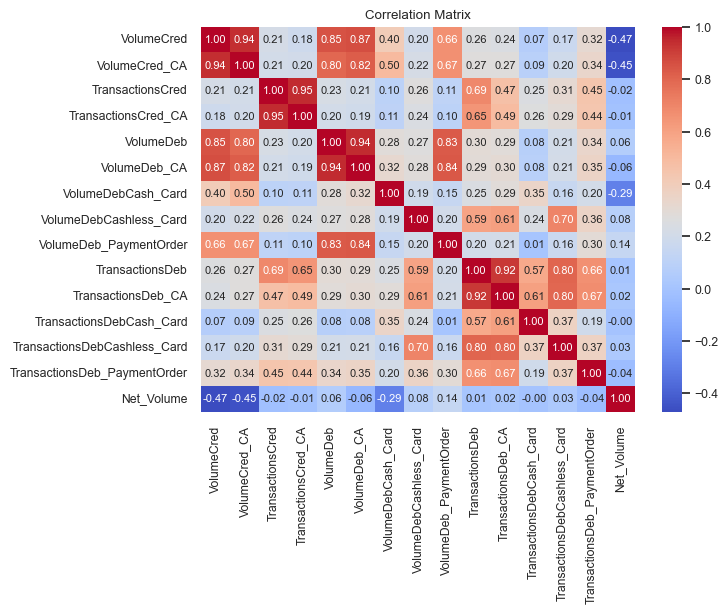

In [398]:
# understand correlation between variables
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 5))
plt.title('Correlation Matrix')
corr_matrix = Inflow_Outflow_df.iloc[:,1:].corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 8},cmap='coolwarm',fmt='.2f')
plt.show()

In [399]:
# drop highly correlated variables
Inflow_Outflow_df_final = Inflow_Outflow_df.drop(['VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'TransactionsDeb_CA'], axis=1)

#### Findings on Financial Transactions
- There are a few variables with _CA that are almost identical ie. multicolinearity and we will drop those above 0.9 ie. the columns suffix with _CA

#### Sales and Revenue

In [400]:
# import sales and revenue data
Sales_Revenues_df = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx',sheet_name=4)
print(Sales_Revenues_df.shape)
print(f'unique client id: {Sales_Revenues_df.Client.nunique()}')
Sales_Revenues_df.head()

(969, 7)
unique client id: 969


,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


In [401]:
# checking product holdings of customers
Sales_Revenues_df[['Sale_MF','Sale_CC','Sale_CL']].groupby(['Sale_MF','Sale_CC','Sale_CL']).value_counts()

Sale_MF  Sale_CC  Sale_CL
0        0        0          400
                  1          179
         1        0          142
                  1           55
1        0        0          106
                  1           42
         1        0           31
                  1           14
Name: count, dtype: int64

In [402]:
Sales_Revenues_df.iloc[:,4:].sum()

Revenue_MF    1865.340000
Revenue_CC    2628.728929
Revenue_CL    3492.489286
dtype: float64

In [403]:
# calculating overall mean revenue to be used to calculated expected revenue
Revenue_MF_mean = Sales_Revenues_df[Sales_Revenues_df['Sale_MF']>0].Revenue_MF.mean()
Revenue_CC_mean = Sales_Revenues_df[Sales_Revenues_df['Sale_CC']>0].Revenue_CC.mean()
Revenue_CL_mean = Sales_Revenues_df[Sales_Revenues_df['Sale_CL']>0].Revenue_CL.mean()
print(Revenue_MF_mean)
print(Revenue_CC_mean)
print(Revenue_CL_mean)

9.664974093264249
10.862516233766232
12.043066502463054


In [404]:
Sales_Revenues_df_final = Sales_Revenues_df.copy()

In [405]:
Sales_Revenues_df_final['Training_Data_Flag'] = 1

In [406]:
Sales_Revenues_df_final.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Training_Data_Flag
0,1094,0,1,0,0.000000,5.138571,0.0000,1
1,1484,1,0,1,25.609107,0.000000,8.7225,1
2,20,0,1,0,0.000000,3.822500,0.0000,1
3,1193,0,0,0,0.000000,0.000000,0.0000,1
4,142,0,0,0,0.000000,0.000000,0.0000,1


#### Findings on Sales and Revenue
- Revenue generated from CC and CL are higher than MF and in CC, we see more variance in the revenue generated, probably due to the income gap and some customers holding multiple cards. Would be interesting if we have that information to get more insights.
- As mentioned earlier, we will use the overall mean to get the expected revenue later on instead of a separate model to predict revenue spent

### Merge dataframes

In [407]:
df_list = [Soc_Dem_df_final, Products_ActBalance_df_final, Inflow_Outflow_df_final, Sales_Revenues_df_final]

In [408]:
def merge_df(list): 
    left = list[0]
    for table in list[1:]:
        merged = pd.merge(left, table, on='Client', how='outer')
        left = merged
    return merged

In [409]:
# merging the data together
master_df = merge_df(df_list)

In [410]:
# only look at eligible records based on assumptions made
master_df = master_df[master_df['Eligible_Flag']==1]

In [411]:
print(master_df.shape)
print(f'unique client id: {master_df.Client.nunique()}')
master_df.head()

(1278, 40)
unique client id: 1278


,Client,Age,Tenure,Sex_F,Sex_M,Eligible_Flag,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Total_Asset_Balance,Total_Liability_Balance,Net_Asset_Balance,Gearing_Ratio,VolumeCred,TransactionsCred,VolumeDeb,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Net_Volume,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Training_Data_Flag
0,1,51.0,7.0,1.0,0.0,1.0,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.0,0.0,0.000000,0.000000,1333.802857,0.000000,1333.802857,0.000000,1678.946429,25.0,1891.353214,250.000000,283.089286,247.607143,50.0,3.0,12.0,9.0,212.406786,1.0,0.0,0.0,26.972679,0.0,0.0,1.0
3,4,24.0,153.0,0.0,1.0,1.0,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.0,0.0,1110.381786,0.000000,1676.277857,1110.381786,565.896071,0.662409,1872.483571,9.0,3614.747500,714.285714,526.037500,1963.165357,41.0,6.0,12.0,13.0,1742.263929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,58.0,200.0,1.0,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.0,0.0,0.000000,0.000000,13433.199643,0.000000,13433.199643,0.000000,4372.773929,23.0,5868.460714,157.142857,832.175000,1779.571429,44.0,4.0,17.0,13.0,1495.686786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,24.0,19.0,1.0,0.0,1.0,1,0.0,0.0,0.0,0.0,1.0,4.297143,0.000000,0.0,0.0,0.000000,1982.071071,4.297143,1982.071071,-1977.773929,461.253241,501.131429,3.0,436.285714,357.142857,0.000000,0.000000,8.0,1.0,0.0,0.0,-64.845714,0.0,0.0,0.0,0.000000,0.0,0.0,1.0
6,7,55.0,227.0,1.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,879.685000,0.000000,0.0,0.0,0.000000,0.000000,879.685000,0.000000,879.685000,0.000000,387.504643,2.0,99.043929,17.857143,69.151071,10.714286,10.0,1.0,6.0,1.0,-288.460714,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
master_df.set_index('Client', inplace=True)

## Models

In [413]:
# splitting the data into training and application 
Training_df = master_df[master_df['Training_Data_Flag']==1]
Application_df = master_df[master_df['Training_Data_Flag']!=1].iloc[:,:-7]

In [414]:
X = Training_df.iloc[:,:-7]

In [415]:
y_MF = Training_df['Sale_MF']
y_CC = Training_df['Sale_CC']
y_CL = Training_df['Sale_CL']

In [416]:
# the parameter grid for gridsearchcv
param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [5,8, None],
    'min_samples_split' : [2,5,8]
}   

In [417]:
def tuning(X_train, y_train, grid):
    rf = RandomForestClassifier()
    gridsearch = GridSearchCV(estimator=rf, param_grid=grid, cv=3, n_jobs=-1, scoring='f1')
    gridsearch.fit(X_train, y_train)
    return gridsearch

### Mutual Fund

In [418]:
def model_train(X,y,test_size):
    """
    Returns the best Random Forest model after applying gridsearch and prints its model score
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    gridsearch_ML = tuning(X_train, y_train, param_grid)
    best_model = gridsearch_ML.best_estimator_
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f'Accuracy: {best_model.score(X_test,y_test)}')
    print(f'AUC: {roc_auc_score(y_test, y_pred)}')
    return best_model

In [419]:
MF_model = model_train(X,y_MF,0.2)

[[122   2]
 [ 30   2]]
Accuracy: 0.7948717948717948
AUC: 0.5231854838709677


In [420]:
# store the model in a pickle file
with open('MF_model.pkl', 'wb') as f:
    pickle.dump(MF_model, f)

In [421]:
# to generate the probability to purchase MF
Application_df['MF_probablity'] = MF_model.predict_proba(Application_df)[:,1]

In [422]:
def plot_feature_importance(model):
    features = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

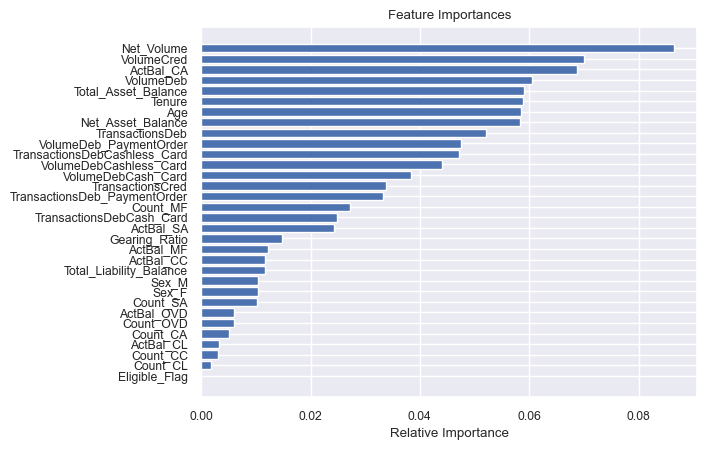

In [423]:
# displaying the important variables 
plot_feature_importance(MF_model)

### Credit Card

In [424]:
CC_model = model_train(X,y_CC,0.2)

[[113   0]
 [ 35   8]]
Accuracy: 0.7756410256410257
AUC: 0.5930232558139534


In [425]:
with open('CC_model.pkl', 'wb') as f:
    pickle.dump(CC_model, f)

In [426]:
Application_df['CC_probablity'] = CC_model.predict_proba(Application_df.iloc[:,:-1])[:,1]

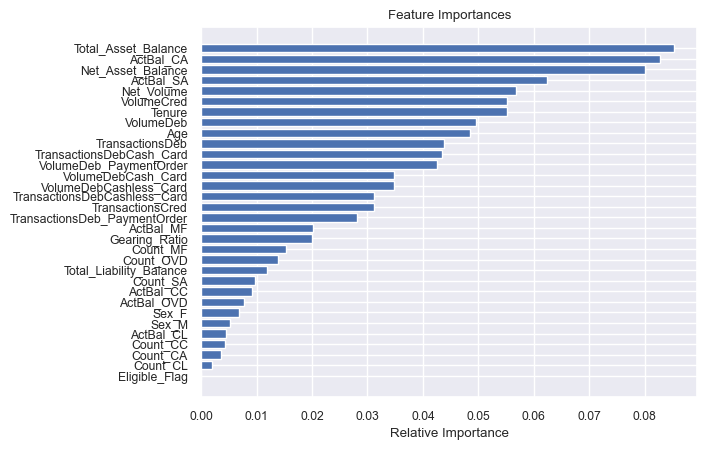

In [427]:
plot_feature_importance(CC_model)

### Consumer Loan

In [428]:
CL_model = model_train(X,y_CL,0.2)

[[109   4]
 [ 41   2]]
Accuracy: 0.7115384615384616
AUC: 0.5055566989092406


In [429]:
with open('CL_model.pkl', 'wb') as f:
    pickle.dump(CL_model, f)

In [430]:
Application_df['CL_probablity'] = CL_model.predict_proba(Application_df.iloc[:,:-2])[:,1]

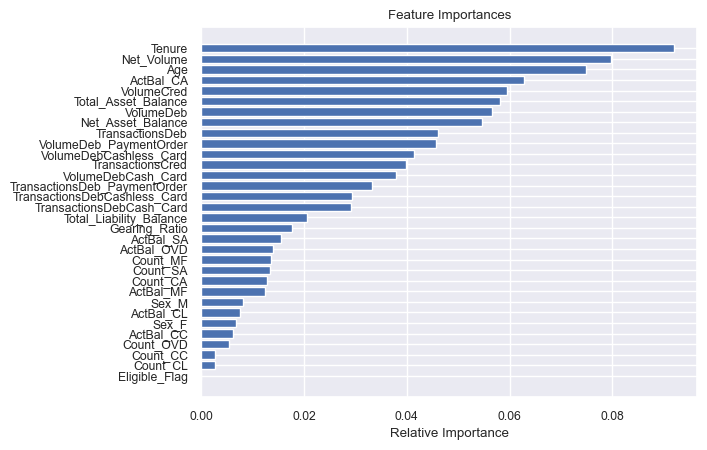

In [431]:
plot_feature_importance(CL_model)

### Remarks after generating models
- Although accuracy score is relative higher, it cannot be used as determining scoring method because of the unbalanced nature of the data ie. only a small percentage bought respective product. AUC and precision recall are usually used but here the AUC score are not acceptable. Since model performance is not graded, I will leave it as it is due to time limit.
- The important variables looks interesting and it would be valuable if we have time to delve deeper into the relationship of how these variables relate to the target variable. 

### Final output

In [432]:
# To calcuted the expected revenue
Application_df['MF_expected_revenue'] = Application_df['MF_probablity']*Revenue_MF_mean

In [433]:
Application_df['CC_expected_revenue'] = Application_df['CC_probablity']*Revenue_CC_mean

In [434]:
Application_df['CL_expected_revenue'] = Application_df['CL_probablity']*Revenue_CL_mean

In [435]:
# To identify the offer with highest expected revenue
Application_df['Highest_Revenue'] = Application_df.apply(lambda x: max([x['MF_expected_revenue'], x['CC_expected_revenue'], x['CL_expected_revenue']]), axis=1)
Application_df['Recommended_Offer'] = Application_df.apply(lambda x: ['MF', 'CC', 'CL'][np.argmax([x['MF_expected_revenue'], x['CC_expected_revenue'], x['CL_expected_revenue']])], axis = 1)

In [436]:
Final_output_df = Application_df.sort_values(by=['Highest_Revenue'],ascending=False)

In [437]:
# To calculate the total expected revenue for the targeted customers
print(f'The expected revenue from this campaign is {Final_output_df.iloc[:100,:].Highest_Revenue.sum():.2f}') 
# There is no unit or currency given for Sales and Revenue numbers so I leave it as is

The expected revenue from this campaign is 622.12


### Remarks
- It is not mentioned whether those who already has MF, CC and CL needs to be excluded. Need a conversation with the campaign team. I will assume that customer can take up more than 1 product, for example multiple credit cards. So here I did not exclude them
- Typically Marketing team has a budget, say for example able to target 100 mailers, so in this case, I kept the list at 100.